## 주요 기능

- **사이클 및 분기**: 애플리케이션에서 루프와 조건문을 구현할 수 있습니다.
- **지속성**: 그래프의 각 단계 후 자동으로 상태를 저장합니다. 그래프 실행을 언제든지 일시 중지하고 다시 시작하여 오류 복구, human-in-the-loop 워크플로우, 시간 여행 등을 지원합니다.
- **Human-in-the-Loop**: 에이전트가 계획한 다음 작업을 승인하거나 수정하기 위해 그래프 실행을 중단할 수 있습니다.
- **스트리밍 지원**: 각 노드에서 생성된 출력(토큰 스트리밍 포함)을 실시간으로 스트리밍할 수 있습니다.
- **LangChain과의 통합**: LangGraph는 LangChain 및 LangSmith와 원활하게 통합됩니다(필수는 아님).


### Installation

In [1]:
%pip install langgraph

/Users/sungwoo/workspace/sungwooLab/langGraph-tour/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install python-dotenv langchain-openai

/Users/sungwoo/workspace/sungwooLab/langGraph-tour/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


### gpt사용을 위한 openAi API key 셋팅

In [11]:
import os
from dotenv import load_dotenv

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 OpenAI API 키를 가져옵니다.
openai_api_key = os.getenv("OPENAI_API_KEY")

# API 키가 존재하지 않는 경우 에러를 발생시킵니다.
if not openai_api_key:
    # API 키가 없다는 에러 메시지를 출력하고 프로그램을 종료합니다.
    raise ValueError("OpenAI API 키가 없습니다. 한 번 더 확인 부탁드립니다.")

In [12]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


# 에이전트가 사용할 도구 정의
@tool
def recommend_recipe(dish: str):
    """주어진 요리에 대한 간단한 레시피를 제공합니다."""
    recipes = {
        "파스타": "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘. 면을 삶고 소스를 부어주세요.",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요."
    }
    return recipes.get(dish, "죄송하지만 해당 요리의 레시피를 찾을 수 없습니다.")

# 도구 리스트에 추가
tools = [recommend_recipe]

# ToolNode 생성
tool_node = ToolNode(tools)

In [18]:
# 모델을 GPT로 변경
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

# 계속할지 여부를 결정하는 함수 정의
def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    # LLM이 도구 호출을 하면 "tools" 노드로 라우팅
    if last_message.tool_calls:
        return "tools"
    # 그렇지 않으면 중지(사용자에게 응답)
    return END

# 모델을 호출하는 함수 정의
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # 기존 목록에 추가되기 때문에 목록을 반환합니다.
    return {"messages": [response]}


# 새로운 그래프 정의
workflow = StateGraph(MessagesState)

# 사이클링할 두 노드 정의
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 진입점을 `agent`로 설정
# 이는 첫 번째로 호출되는 노드를 의미합니다.
workflow.set_entry_point("agent")

# 조건부 경로 추가
workflow.add_conditional_edges(
    # 먼저, 시작 노드를 정의합니다. `agent`를 사용합니다.
    # 이는 `agent` 노드가 호출된 후의 경로를 의미합니다.
    "agent",
    # 다음으로, 어느 노드가 다음에 호출될지 결정하는 함수를 전달합니다.
    should_continue,
)

# `tools`에서 `agent`로의 일반 경로 추가
# 이는 `tools`가 호출된 후 `agent` 노드가 다음에 호출된다는 것을 의미합니다.
workflow.add_edge("tools", 'agent')

In [14]:
# 그래프 실행 간 상태를 유지하기 위해 메모리 초기화
checkpointer = MemorySaver()

# 마지막으로 컴파일합니다!
# 이를 LangChain Runnable로 컴파일하여,
# 다른 runnable처럼 사용할 수 있게 합니다.
# 그래프를 컴파일할 때 메모리를 옵션 checkpointer로 전달할수 있습니다.
app = workflow.compile(checkpointer=checkpointer)

In [15]:
# 에이전트와의 상호작용
final_state = app.invoke(
    {"messages": [HumanMessage(content="파스트 레시피 알려줄래?")]},
    config={"configurable": {"thread_id": 100}}
)
final_state["messages"][-1].content

'파스타 레시피는 다음과 같습니다:\n\n### 재료\n- 스파게티 면\n- 토마토 소스\n- 올리브 오일\n- 마늘\n\n### 조리 방법\n1. 스파게티 면을 끓는 물에 삶아주세요.\n2. 면이 익으면 물기를 빼고, 팬에 올리브 오일과 다진 마늘을 넣고 볶아주세요.\n3. 볶은 마늘에 토마토 소스를 부어 잘 섞어주세요.\n4. 삶은 스파게티 면을 소스에 넣고 잘 버무려서 완성합니다.\n\n맛있게 드세요!'

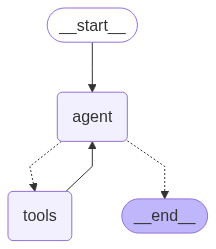

In [16]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

동일한 "thread_id"를 전달하면, 저장된 상태(즉, 저장된 메시지 목록)를 통해 대화 문맥이 유지됩니다.

In [17]:
# 동일한 "thread_id"를 사용하여 Runnable을 다시 호출
final_state = app.invoke(
    {"messages": [HumanMessage(content="방금 어떤 레시피를 알려주었지?")]},
    config={"configurable": {"thread_id": 100}}
)
final_state["messages"][-1].content

'방금 스파게티 파스타 레시피를 알려드렸습니다. 재료로는 스파게티 면, 토마토 소스, 올리브 오일, 마늘이 필요하며, 면을 삶고 소스를 부어 만드는 간단한 방법이었습니다.'